In [102]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import geopandas as gpd
import numpy as np
from tqdm import tqdm_notebook
from shapely.geometry import Point, LineString
import os

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

import folium
import geoplot


data_path = '/home/fterroso/data/'
tweets_path = '/home/fterroso/projects/twitter-crawler/streaming_tweets/'

### Read census areas file

In [103]:
census_zones_gdf = gpd.read_file(data_path + 'Spain-census-zones/SECC_CPV_E_20111101_01_R_INE.shp')
census_zones_gdf.head()

OBJECTID       CUSEC  CUMUN CSEC CDIS CMUN CPRO CCA    CUDIS   OBS CNUT0 CNUT1 CNUT2 CNUT3  CLAU2         NPRO         NCA              NMUN    Shape_Leng    Shape_area     Shape_len                                           geometry
0         1  0100101001  01001  001   01  001   01  16  0100101  None    ES     2     1     1  01001  Araba/Álava  País Vasco  Alegría-Dulantzi  34474.734278  1.551393e+07  34474.734278  (POLYGON ((541571.2089999998 4745050.1195, 541...
1         2  0100101002  01001  002   01  001   01  16  0100101  None    ES     2     1     1  01001  Araba/Álava  País Vasco  Alegría-Dulantzi   8620.042319  4.410972e+06   8620.042319  POLYGON ((541370.9625000004 4745058.6226, 5413...
2         3  0100201001  01002  001   01  002   01  16  0100201  None    ES     2     1     1  01002  Araba/Álava  País Vasco           Amurrio  47379.027701  3.535737e+07  47379.027700  (POLYGON ((503618.5531000001 4759559.7981, 503...
3         4  0100201002  01002  002   01  002   01  16  0100201  None    ES     2     1     1  01002  Araba/Álava  País Vasco           Amurrio  31169.713203  3.873652e+07  31169.713203  POLYGON ((508942.5675999997 4765890.6743, 5089...
4         5  0100201003  01002  003   01  002   01  16  0100201  None    ES     2     1     1  01002  Araba/Álava  País Vasco           Amurrio   4244.249418  8.494741e+05   4244.249418  POLYGON ((499919.4973999998 4766600.281400001,...

In [104]:
census_zones_gdf.crs

{'init': 'epsg:25830'}

In [105]:
census_zones_gdf.shape

(35960, 22)

### Read province

In [106]:
province_gdf = gpd.read_file(os.path.join('data', 'provinces_with_code.geojson'), encoding='utf-8').to_crs({'init': 'epsg:25830'})
province_gdf.head()

NATCODE           NAMEUNIT CODEUNIT                                           geometry
0  34104600000  València/Valencia       46  (POLYGON ((653037.6610938488 4429500.236400451...
1  34084500000             Toledo       45  POLYGON ((294238.4652867644 4416957.42816667, ...
2  34024400000             Teruel       44  POLYGON ((765333.0112961649 4512252.350615062,...
3  34094300000          Tarragona       43  (POLYGON ((813560.4348489635 4504876.753000001...
4  34074200000              Soria       42  POLYGON ((583890.5889343297 4603311.305096235,...

### Read trips

In [107]:
ca_trips_gdf = gpd.read_file(os.path.join('data', 'census_trips.geojson'), 
                          driver='GeoJSON', 
                          encoding='utf-8').to_crs({'init': 'epsg:25830'})
ca_trips_gdf['timestamp_o']= pd.to_datetime(ca_trips_gdf['timestamp_o'])
ca_trips_gdf['timestamp_d']= pd.to_datetime(ca_trips_gdf['timestamp_d'])


In [108]:
ca_trips_gdf.shape

(17260, 12)

In [109]:
ca_trips_gdf['dist_km'] = ca_trips_gdf['geometry'].apply(lambda r: r.length/1000)

In [110]:
ca_trips_gdf['time_length']= ca_trips_gdf['timestamp_d'] - ca_trips_gdf['timestamp_o']

In [111]:
ca_trips_gdf = ca_trips_gdf[ca_trips_gdf['time_length']>timedelta(minutes=1)]

In [112]:
def calculate_speed_fn(row):
    return row['dist_km']/(row['time_length'].total_seconds()/3600)

In [113]:
ca_trips_gdf['speed_km_h'] = ca_trips_gdf.apply(calculate_speed_fn, axis=1)

In [114]:
ca_trips_gdf= ca_trips_gdf[ca_trips_gdf['speed_km_h'] <=500]

In [115]:
ca_trips_gdf.head()

user_id              tw_id_o         timestamp_o     CUSEC_o CPRO_o CCA_o              tw_id_d         timestamp_d     CUSEC_d CPRO_d CCA_d                                           geometry   dist_km time_length  speed_km_h
0  168285338  1234173492922322945 2020-03-01 17:47:45  2807901066     28    13  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  LINESTRING (440796.4167641253 4473756.06043492...  0.912968    00:06:52    7.977386
1  168285338  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  1234186473815015425 2020-03-01 18:39:20  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...  2.288855    00:44:43    3.071144
2  168285338  1235648826431717377 2020-03-05 19:30:12  2807901031     28    13  1235650767526055936 2020-03-05 19:37:54  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...  2.288855    00:07:42   17.835236
3  168285338  1256741073700954117 2020-05-03 00:23:15  2807901045     28    13  1256877766752034817 2020-05-03 09:26:25  2807902083     28    13  LINESTRING (440425.6348667498 4473757.88710830...  2.102432    09:03:10    0.232242
4  168285338  1256877766752034817 2020-05-03 09:26:25  2807902083     28    13  1256926064472756224 2020-05-03 12:38:20  2807901031     28    13  LINESTRING (442012.7041790278 4472378.96245223...  2.288855    03:11:55    0.715578

In [116]:
ca_trips_gdf.shape

(15120, 15)

In [117]:
ca_trips_gdf.crs

{'init': 'epsg:25830'}

In [118]:
ca_trips_gdf

user_id              tw_id_o         timestamp_o     CUSEC_o CPRO_o CCA_o              tw_id_d         timestamp_d     CUSEC_d CPRO_d CCA_d                                           geometry     dist_km time_length  speed_km_h
0                168285338  1234173492922322945 2020-03-01 17:47:45  2807901066     28    13  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  LINESTRING (440796.4167641253 4473756.06043492...    0.912968    00:06:52    7.977386
1                168285338  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  1234186473815015425 2020-03-01 18:39:20  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...    2.288855    00:44:43    3.071144
2                168285338  1235648826431717377 2020-03-05 19:30:12  2807901031     28    13  1235650767526055936 2020-03-05 19:37:54  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...    2.288855    00:07:42   17.835236
3                168285338  1256741073700954117 2020-05-03 00:23:15  2807901045     28    13  1256877766752034817 2020-05-03 09:26:25  2807902083     28    13  LINESTRING (440425.6348667498 4473757.88710830...    2.102432    09:03:10    0.232242
4                168285338  1256877766752034817 2020-05-03 09:26:25  2807902083     28    13  1256926064472756224 2020-05-03 12:38:20  2807901031     28    13  LINESTRING (442012.7041790278 4472378.96245223...    2.288855    03:11:55    0.715578
5                168285338  1256926064472756224 2020-05-03 12:38:20  2807901031     28    13  1256927385938808833 2020-05-03 12:43:36  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...    2.288855    00:05:16   26.075567
6                168285338  1261974615372554240 2020-05-17 10:59:29  2807901119     28    13  1261975731464278017 2020-05-17 11:03:55  2807902083     28    13  LINESTRING (440321.6411852657 4474288.94365936...    2.551024    00:04:26   34.525134
7                168285338  1265547605439844354 2020-05-27 07:37:16  2807903068     28    13  1265556164235976704 2020-05-27 08:11:17  2807902083     28    13  LINESTRING (441941.6325359531 4474236.22196382...    1.858619    00:34:01    3.278309
8                168285338  1268840147103211520 2020-06-05 09:40:39  2807902083     28    13  1268978690936930305 2020-06-05 18:51:11  2807903068     28    13  LINESTRING (442012.7041790278 4472378.96245223...    1.858619    09:10:32    0.202562
9                168285338  1275333457795846144 2020-06-23 07:42:45  2807901003     28    13  1275352986517110784 2020-06-23 09:00:21  2807902083     28    13  LINESTRING (439798.2365269474 4474423.42150996...    3.013914    01:17:36    2.330346
10               168285338  1275725037614612480 2020-06-24 09:38:45  2807902083     28    13  1275831209201934339 2020-06-24 16:40:38  2807901121     28    13  LINESTRING (442012.7041790278 4472378.96245223...    2.656119    07:01:53    0.377752
11               168285338  1275831209201934339 2020-06-24 16:40:38  2807901121     28    13  1275867679220535296 2020-06-24 19:05:33  2807902083     28    13  LINESTRING (439996.3140913351 4474107.87540144...    2.656119    02:24:55    1.099716
12              1722292842  1254617432293085184 2020-04-27 03:44:40  2807902041     28    13  1254627987758120960 2020-04-27 04:26:36  2807902083     28    13  LINESTRING (440831.4647923201 4472081.61093612...    1.218090    00:41:56    1.742896
14              1722292842  1255734543904112642 2020-04-30 05:43:40  2807902083     28    13  1255739220062281730 2020-04-30 06:02:15  2807908171     28    13  LINESTRING (442012.7041790278 4472378.96245223...   11.189913    00:18:35   36.128868
16              1722292842  1261488736602333184 2020-05-16 02:48:46  2807908171     28    13  1261660119240228865 2020-05-16 14:09:47  2807902083     28    13  LINESTRING (443510.5598637293 4483468.17299614...   11.189913    11:21:01    0.985871
17               100257934  1240570965467291650 2020-03-19 09:29:01  2807902083    

### Plot distribution of trips features

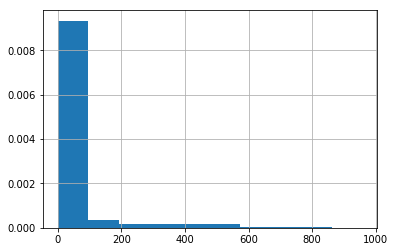

In [119]:
ca_trips_gdf['dist_km'].hist(density=True);

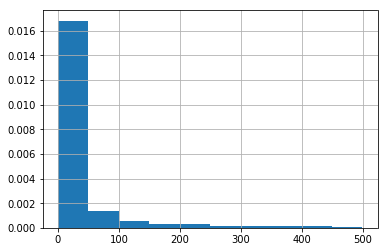

In [120]:
ca_trips_gdf['speed_km_h'].hist(density=True);

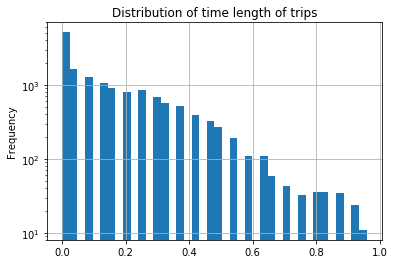

In [121]:
(ca_trips_gdf['time_length'].astype('timedelta64[h]')/24).plot.hist(bins=40, logy=True, grid=True, title="Distribution of time length of trips");

### Number of trips inter-province

In [122]:
ca_trips_gdf[ca_trips_gdf['CPRO_o']!=ca_trips_gdf['CPRO_d']].shape

(2255, 15)

### Calculate stats of CAs

In [123]:
def generate_stats_per_ca_fn(trips_gdf, trip_edge, ca_granularity):
    count_df = trips_gdf.groupby('{}_{}'.format(ca_granularity, trip_edge)).count()['tw_id_{}'.format(trip_edge)].to_frame()
    count_df.columns= ['n_trips']#.format(ca_granularity).split()
    count_df.sort_values(by='n_trips', ascending=False, inplace=True)
    return count_df

CUSEC study

In [124]:
count_origin_df = generate_stats_per_ca_fn(ca_trips_gdf, 'o', 'CUSEC')

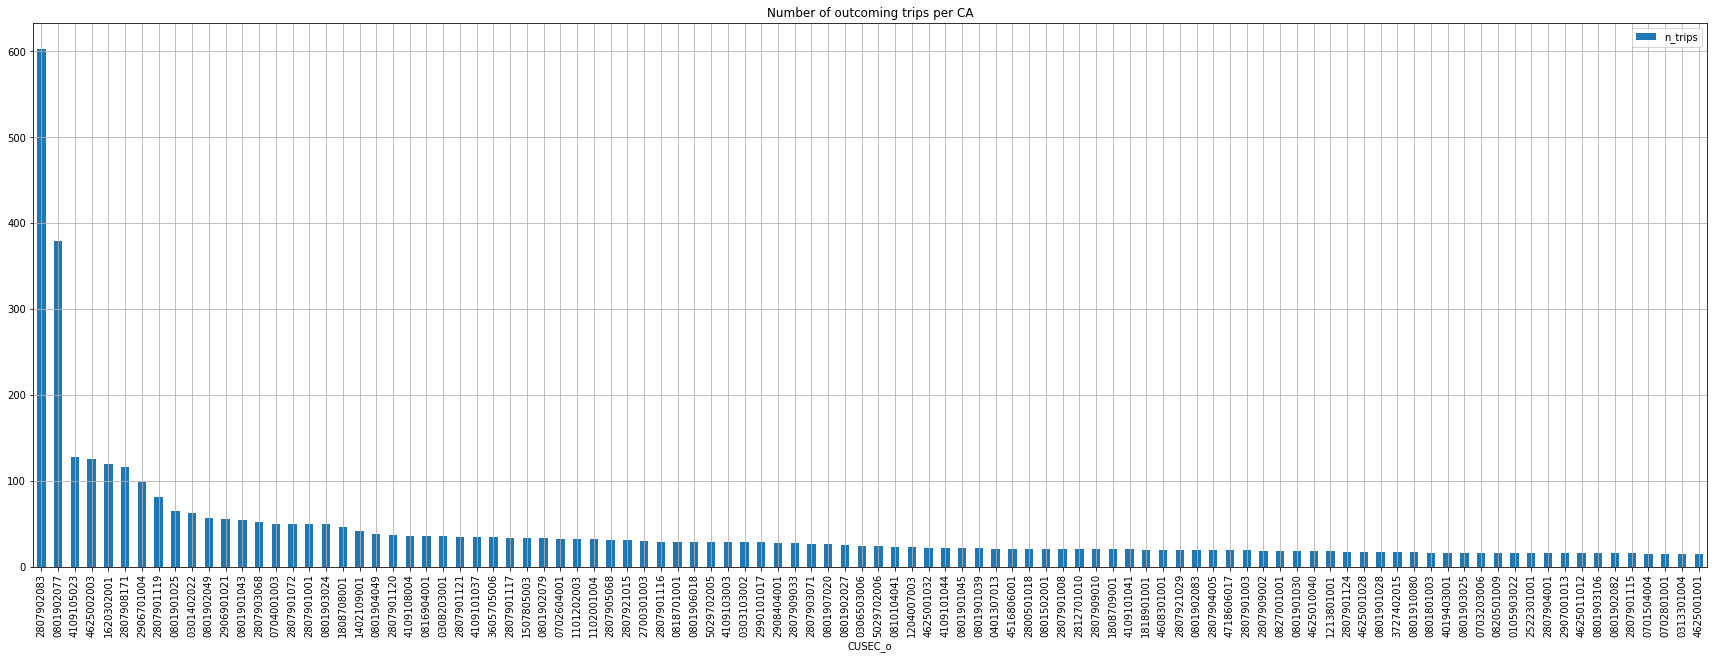

In [125]:
count_origin_df[0:100].plot(figsize=(30,10),kind='bar', grid=True, title='Number of outcoming trips per CA');

CPRO study

In [126]:
inter_prov_trips_gdf = ca_trips_gdf[ca_trips_gdf['CPRO_o']!=ca_trips_gdf['CPRO_d']]

In [127]:
count_origin_pro_df = generate_stats_per_ca_fn(inter_prov_trips_gdf, 'o', 'CPRO')

In [128]:
count_origin_pro_df.head()

n_trips
CPRO_o         
28          366
08          262
41          141
16          137
29          114

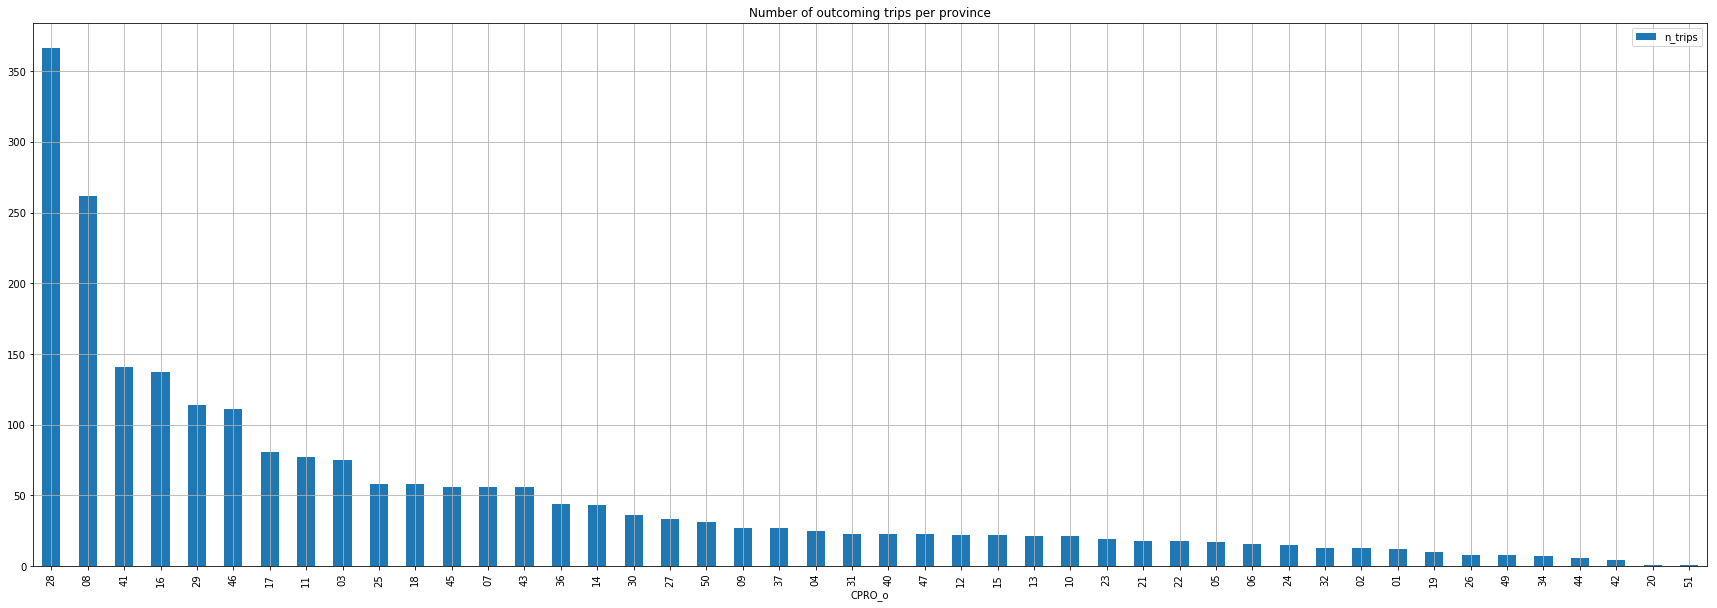

In [129]:
count_origin_pro_df[0:100].plot(figsize=(30,10),kind='bar', grid=True, title='Number of outcoming trips per province');

### Plot CUSEC origin trips in map

In [130]:
origin_regions_lst = count_origin_df.index.tolist()

In [131]:
t_census_areas_gdf = census_zones_gdf[census_zones_gdf['CUSEC'].isin(origin_regions_lst)]

In [132]:
t_census_areas_gdf = pd.merge(t_census_areas_gdf, count_origin_df.reset_index(), left_on='CUSEC', right_on='CUSEC_o')

In [133]:
t_census_areas_gdf.head()

OBJECTID       CUSEC  CUMUN CSEC CDIS CMUN CPRO CCA    CUDIS   OBS CNUT0 CNUT1 CNUT2 CNUT3  CLAU2         NPRO         NCA                         NMUN    Shape_Leng    Shape_area     Shape_len                                           geometry     CUSEC_o  n_trips
0        31  0103101001  01031  001   01  031   01  16  0103101  None    ES     2     1     1  01031  Araba/Álava  País Vasco                    Laguardia  87711.717051  8.041601e+07  87711.717051  (POLYGON ((538984.6357000005 4718139.608100001...  0103101001        3
1        48  0103701001  01037  001   01  037   01  16  0103701  None    ES     2     1     1  01037  Araba/Álava  País Vasco                Arraia-Maeztu  60761.315212  1.227207e+08  60761.315212  POLYGON ((548521.8232000005 4739513.019200001,...  0103701001        1
2        56  0104701001  01047  001   01  047   01  16  0104701  None    ES     2     1     1  01047  Araba/Álava  País Vasco  Ribera Baja/Erribera Beitia  30896.069921  2.536652e+07  30896.069921  POLYGON ((511330.6618999997 4732622.7268, 5113...  0104701001        1
3        73  0105901007  01059  007   01  059   01  16  0105901  None    ES     2     1     1  01059  Araba/Álava  País Vasco              Vitoria-Gasteiz    653.947586  1.687114e+04    653.947586  POLYGON ((526706.9183999998 4744471.9805, 5267...  0105901007        1
4        74  0105901008  01059  008   01  059   01  16  0105901  None    ES     2     1     1  01059  Araba/Álava  País Vasco              Vitoria-Gasteiz    796.331291  3.571224e+04    796.331291  POLYGON ((526947.29 4744449.475, 526991.348199...  0105901008        1

In [134]:
t_census_areas_gdf.shape

(5333, 24)

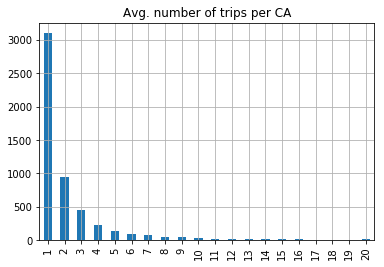

In [135]:
t_census_areas_gdf['n_trips'].value_counts().sort_index(axis=0)[:20].plot(kind='bar', grid=True, title="Avg. number of trips per CA");

In [136]:
t_census_areas_gdf['n_trips'].max()

603

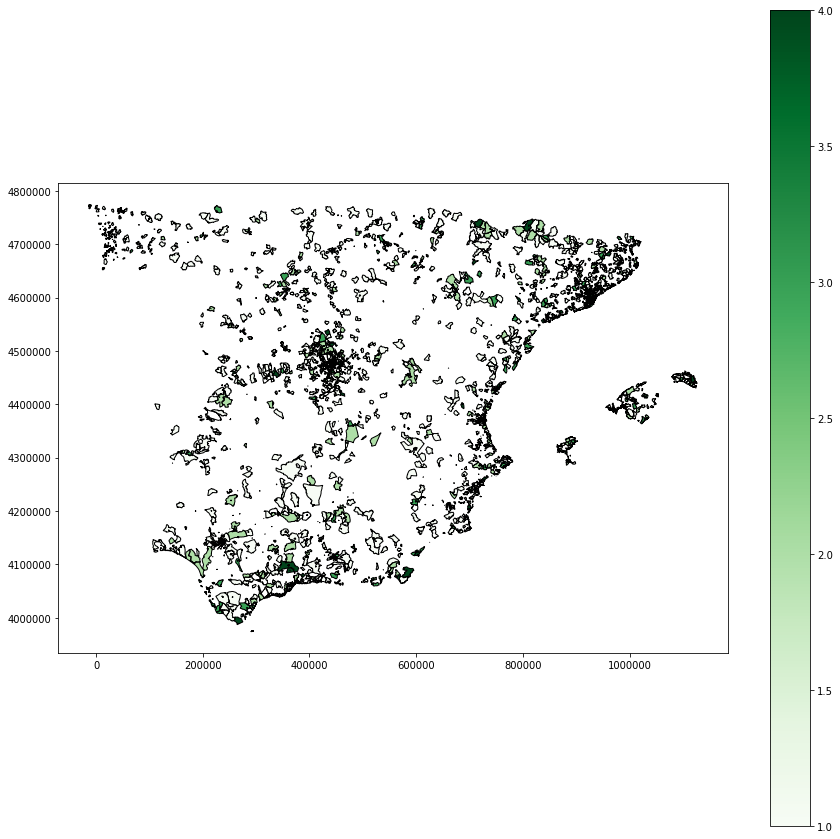

In [137]:
ax=t_census_areas_gdf[t_census_areas_gdf['n_trips']<5].plot(figsize=(15,15), column='n_trips', legend=True, cmap='Greens');
t_census_areas_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax); 

### Plot CPROV origin trips in map

In [138]:
origin_regions_lst = count_origin_pro_df.index.tolist()
t_prov_gdf = province_gdf[province_gdf['CODEUNIT'].isin(origin_regions_lst)]
t_prov_gdf = pd.merge(t_prov_gdf, count_origin_pro_df.reset_index(), left_on='CODEUNIT', right_on='CPRO_o')

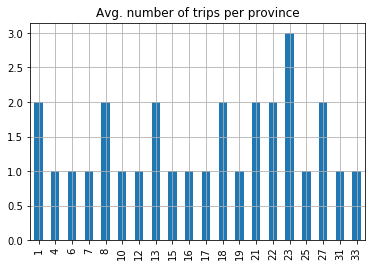

In [139]:
t_prov_gdf['n_trips'].value_counts().sort_index(axis=0)[:20].plot(kind='bar', grid=True, title="Avg. number of trips per province");

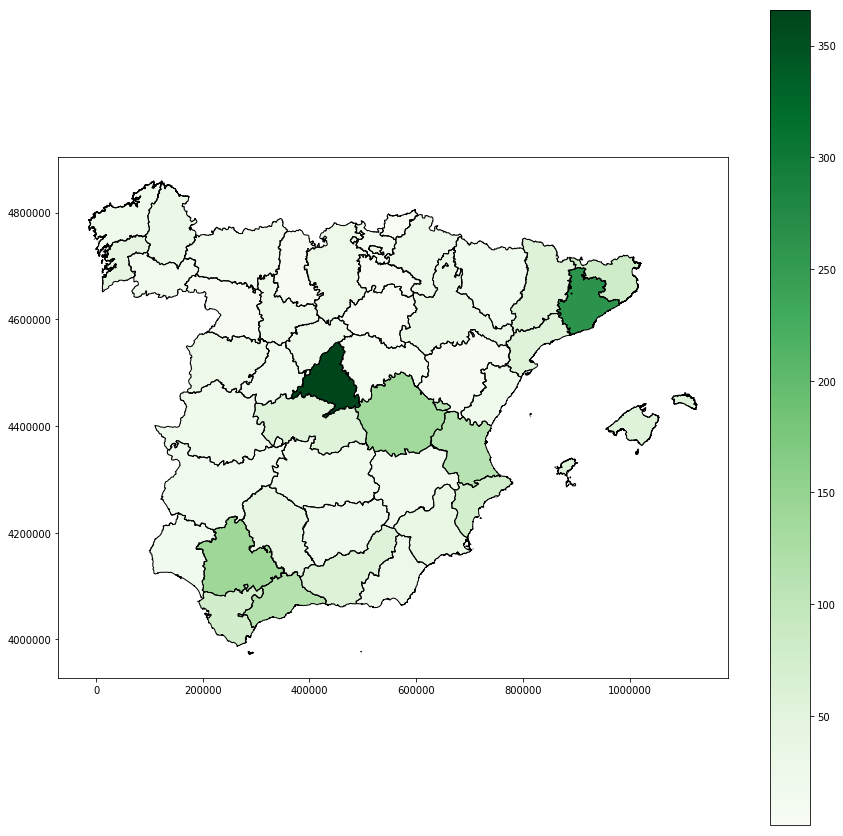

In [140]:
ax=t_prov_gdf.plot(figsize=(15,15), column='n_trips', legend=True, cmap='Greens');
t_prov_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax); #Use your second dataframe

-----------------------------------

In [141]:
def add_map_layer(folium_map, gdf, layer_name, column_names):
    folium.GeoJson(gdf,
                   tooltip=folium.features.GeoJsonTooltip(fields=column_names, localize=True),
                   style_function= lambda x:{
                   'opacity': 0.6,
                   'fillOpacity': 0.0,
                   },
                   name=layer_name).add_to(folium_map);

In [142]:
def generate_trip_map_fn(trips_gdf, zones_gdf):
    origin_areas = trips_gdf['CUSEC_o'].unique().tolist()
    destination_areas = trips_gdf['CUSEC_d'].unique().tolist()
    target_areas_lst = origin_areas + destination_areas
    target_zones_gdf = zones_gdf[zones_gdf['CUSEC'].isin(target_areas_lst)]
    
    trips_gdf['timestamp_o'] = trips_gdf['timestamp_o'].astype(str)
    trips_gdf['timestamp_d'] = trips_gdf['timestamp_d'].astype(str)

    #print(target_zones_gdf)
    spain_map = folium.Map([40.411644, -3.657904], zoom_start = 6)
    add_map_layer(spain_map, trips_gdf['user_id dist_km timestamp_o timestamp_d speed_km_h geometry'.split()], 'trips', ['user_id','dist_km','timestamp_o','timestamp_d','speed_km_h'])
    add_map_layer(spain_map, target_zones_gdf[['CUSEC', 'geometry']], 'ca',['CUSEC'])

    return spain_map

In [143]:
d=ca_trips_gdf.sample(200)

In [144]:
d

user_id              tw_id_o         timestamp_o     CUSEC_o CPRO_o CCA_o              tw_id_d         timestamp_d     CUSEC_d CPRO_d CCA_d                                           geometry     dist_km time_length  speed_km_h
8167             158801497  1264307637233090560 2020-05-23 21:30:05  2607102002     26    17  1264316250525745152 2020-05-23 22:04:18  0105905024     01    16  LINESTRING (512509.5571723247 4713857.25183863...   35.752256    00:34:13   62.692704
15199           1488025868  1235524279757926401 2020-03-05 11:15:17  4109101027     41    01  1235524638786105350 2020-03-05 11:16:43  4109101040     41    01  LINESTRING (234195.0960141517 4142496.75146934...    0.803687    00:01:26   33.642726
16777           3293994760  1255034024243990530 2020-04-28 07:20:03  2806503021     28    13  1255081074146922498 2020-04-28 10:27:01  2810601004     28    13  LINESTRING (436255.1258132374 4461016.43374642...    6.685987    03:06:58    2.145619
13906           3851738128  1263048196831535105 2020-05-20 10:05:31  2807908171     28    13  1263049396624728065 2020-05-20 10:10:17  2807902083     28    13  LINESTRING (443510.5598637293 4483468.17299614...   11.189913    00:04:46  140.852057
5808            4188045255  1263180858065854466 2020-05-20 18:52:39  4314804004     43    09  1263181747971211264 2020-05-20 18:56:12  4317101008     43    09  LINESTRING (856994.7273532078 4560806.86792739...    8.124845    00:03:33  137.321326
13508            116165940  1258037387243868160 2020-05-06 14:14:20  1501304002     15    12  1258045153765396480 2020-05-06 14:45:12  3602201001     36    12  LINESTRING (32001.39340140217 4764646.34856653...   45.279065    00:30:52   88.015461
13302            252152349  1261579402028212227 2020-05-16 08:49:03  3002402013     30    14  1261753029138710533 2020-05-16 20:18:59  3002401008     30    14  LINESTRING (613498.0467631365 4168023.88460757...    1.398822    11:29:56    0.121648
2873             277728553  1272681356817022977 2020-06-16 00:04:15  2807909002     28    13  1273015310300348424 2020-06-16 22:11:16  2807902083     28    13  LINESTRING (435871.8771888415 4474972.13425317...    6.665905    22:07:01    0.301394
3434             250224039  1233520788147523588 2020-02-28 22:34:08  4109109033     41    01  1233534884653780999 2020-02-28 23:30:09  4109105023     41    01  LINESTRING (240274.201731716 4143690.402690201...    5.509591    00:56:01    5.901377
10119            128680732  1265597678425169921 2020-05-27 10:56:14  0608801004     06    11  1265740901336432640 2020-05-27 20:25:21  0801902077     08    09  LINESTRING (187295.1210640615 4312814.68692851...  796.494218    09:29:07   83.971628
6242             564690162  1267808388366454784 2020-06-02 13:20:49  0801902077     08    09  1267848518343032834 2020-06-02 16:00:16  0830101004     08    09  LINESTRING (932168.0015591842 4594891.68337841...   14.703529    02:39:27    5.532843
10414             91853106  1238520576379101186 2020-03-13 17:41:30  4625014007     46    10  1238547229603958786 2020-03-13 19:27:25  4625002003     46    10  LINESTRING (727180.3644468724 4373915.29413489...    2.739091    01:45:55    1.551649
985    1047109148364693504  1236240521779179525 2020-03-07 10:41:23  1620302001     16    08  1236352605971939328 2020-03-07 18:06:46  0303103001     03    10  LINESTRING (499999.9999999992 4427757.21862449...  295.566137    07:25:23   39.817314
1555            2884694807  1233027268991168512 2020-02-27 13:53:04  0818706008     08    09  1233086490474930176 2020-02-27 17:48:23  0818404003     08    09  LINESTRING (926225.5783166017 4608275.18633981...    6.857414    03:55:19    1.748473
3987             186256294  1273006796756717568 2020-06-16 21:37:26  2807915050     28    13  1273008107145383941 2020-06-16 21:42:38  2807913014     28    13  LINESTRING (445623.2248546819 4475704.27774368...    6.990306    00:05:12   80.657375
3526              17019245  1272428331145854978 2020-06-15 07:18:49  3002401006    

In [145]:
generate_trip_map_fn(d, census_zones_gdf)

## Study of the evolution of the trips

In [146]:
ca_trips_gdf['date_o']= ca_trips_gdf['timestamp_o'].dt.date

In [147]:
ca_trips_gdf.head(3)

user_id              tw_id_o         timestamp_o     CUSEC_o CPRO_o CCA_o              tw_id_d         timestamp_d     CUSEC_d CPRO_d CCA_d                                           geometry   dist_km time_length  speed_km_h      date_o
0  168285338  1234173492922322945 2020-03-01 17:47:45  2807901066     28    13  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  LINESTRING (440796.4167641253 4473756.06043492...  0.912968    00:06:52    7.977386  2020-03-01
1  168285338  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  1234186473815015425 2020-03-01 18:39:20  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...  2.288855    00:44:43    3.071144  2020-03-01
2  168285338  1235648826431717377 2020-03-05 19:30:12  2807901031     28    13  1235650767526055936 2020-03-05 19:37:54  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...  2.288855    00:07:42   17.835236  2020-03-05

In [148]:
n_trips_per_day = ca_trips_gdf.groupby('date_o').size()

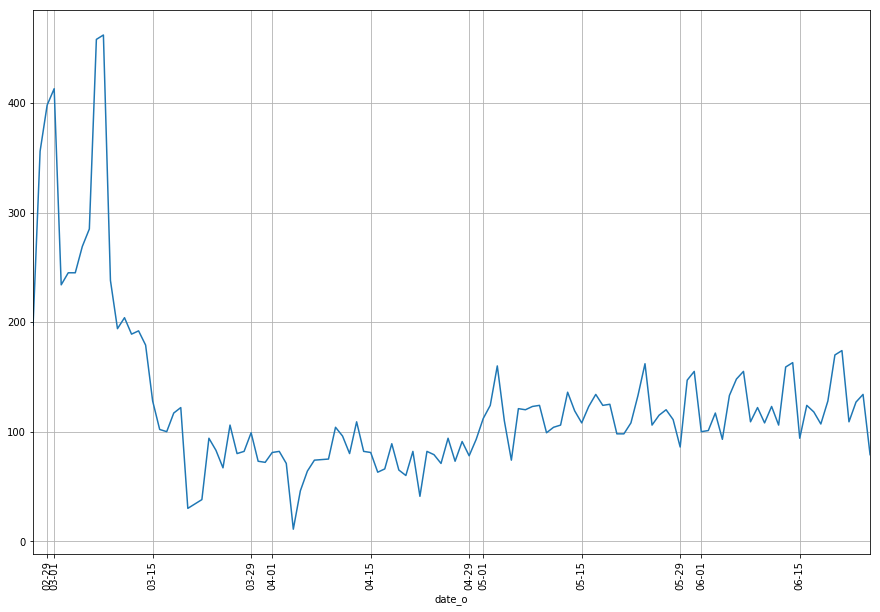

In [149]:
import matplotlib.dates as mdates
ax= n_trips_per_day.plot(grid=True, rot=90, figsize=(15,10));
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))

In [150]:
ca_trips_gdf.head(2)

user_id              tw_id_o         timestamp_o     CUSEC_o CPRO_o CCA_o              tw_id_d         timestamp_d     CUSEC_d CPRO_d CCA_d                                           geometry   dist_km time_length  speed_km_h      date_o
0  168285338  1234173492922322945 2020-03-01 17:47:45  2807901066     28    13  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  LINESTRING (440796.4167641253 4473756.06043492...  0.912968    00:06:52    7.977386  2020-03-01
1  168285338  1234175220807802880 2020-03-01 17:54:37  2807901031     28    13  1234186473815015425 2020-03-01 18:39:20  2807902083     28    13  LINESTRING (439959.6752770033 4473390.85717998...  2.288855    00:44:43    3.071144  2020-03-01

In [151]:
ca_trips_gdf['timestamp_o'] = ca_trips_gdf['timestamp_o'].astype(str)
ca_trips_gdf['timestamp_d'] = ca_trips_gdf['timestamp_d'].astype(str)
ca_trips_gdf['time_length'] = ca_trips_gdf['time_length'].apply(lambda x: x.seconds)
ca_trips_gdf.drop(columns='date_o').to_file(os.path.join('data', 'census_trips_consecutive_enriched.geojson'), driver='GeoJSON', encoding='utf-8')